<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/ARC_AGI_3_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arcprize.org/arc-agi/3/

In [ ]:
# 1. Clone the repository (if you haven't already)
!git clone https://github.com/arcprize/ARC-AGI-3-Agents.git
%cd ARC-AGI-3-Agents

# 2. Install all required dependencies for the repo templates
!pip install -U google-genai requests python-dotenv smolagents langchain-openai langgraph-checkpoint-sqlite langgraph-sdk pillow -q

# 3. Add to system path
import sys
import os
sys.path.append(os.getcwd())

## ONLine

In [ ]:
# --- 1. ROBUST ENVIRONMENT SETUP ---
import subprocess, sys, time, os, json, requests
from google.colab import userdata
from google import genai
from google.genai import types

def setup_repo():
    # Only clone if the directory doesn't exist
    if not os.path.exists("ARC-AGI-3-Agents"):
        !git clone https://github.com/arcprize/ARC-AGI-3-Agents.git
    %cd ARC-AGI-3-Agents

    # Critical 2025 dependencies to prevent ModuleNotFoundErrors
    pkgs = ["google-genai", "requests", "python-dotenv", "smolagents",
            "langchain-openai", "langgraph-checkpoint-sqlite"]
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + pkgs)

setup_repo()

# --- 2. GEMINI 3 AGENT WITH HIGH THINKING ---
class Gemini3FinalAgent:
    def __init__(self, api_key):
        self.client = genai.Client(api_key=api_key)
        self.model_id = "gemini-3-flash-preview"

    def get_action(self, grid, history):
        # ARC-AGI-3 requires identifying secret rules through trial and error
        prompt = f"Interactive Grid (0-15): {grid}\nActions taken: {history[-5:]}\nRespond JSON: {{'thought': '...', 'action_id': 1-6, 'x': int, 'y': int}}"

        # 'high' thinking level is mandatory for ARC-AGI-3 efficiency scores
        config = types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(include_thoughts=True, thinking_level="high"),
            temperature=1.0,
            response_mime_type="application/json"
        )
        response = self.client.models.generate_content(model=self.model_id, contents=prompt, config=config)
        return json.loads(response.text)

# --- 3. THE SELF-HEALING GAME LOOP ---
def run_bulletproof_demo():
    ARC_KEY = userdata.get('ARC_API_KEY')
    GEMINI_KEY = userdata.get('GEMINI')
    ROOT_URL = "https://three.arcprize.org"

    # Priority list of all known public game backends
    GAMES = ["ls20", "as66", "vc33", "lp85", "ft09", "sp80"]

    session = requests.Session()
    session.headers.update({"X-API-KEY": ARC_KEY, "Content-Type": "application/json"})
    agent = Gemini3FinalAgent(GEMINI_KEY)

    # RECOVERY LOOP: Wait until a backend is available
    active_frame = None
    target_game = None
    card_id = None

    print("📡 Watching for available ARC-AGI-3 backends...")
    while not active_frame:
        try:
            # Open a fresh scorecard
            card_resp = session.post(f"{ROOT_URL}/api/scorecard/open", json={"tags": ["notebook-final"]})
            card_id = card_resp.json().get("card_id")

            for g_id in GAMES:
                resp = session.post(f"{ROOT_URL}/api/cmd/RESET", json={"game_id": g_id, "card_id": card_id})
                if resp.status_code == 200:
                    active_frame = resp.json()
                    target_game = g_id
                    print(f"🟢 Success! Connected to {g_id}. Starting Reasoning Loop...")
                    break

            if not active_frame:
                session.post(f"{ROOT_URL}/api/scorecard/close", json={"card_id": card_id})
                print("💤 All backends busy. Retrying in 60s...")
                time.sleep(60)
        except Exception as e:
            print(f"⚠️ Connection error: {e}. Retrying...")
            time.sleep(10)

    # REASONING LOOP: Now we use Gemini
    history = []
    for turn in range(1, 11):
        if active_frame.get("state") != "ACTIVE": break

        decision = agent.get_action(active_frame["grid"], history)
        action_name = f"ACTION{decision['action_id']}"

        # Crucial: Must use the GUID from the LATEST response
        payload = {"game_id": target_game, "card_id": card_id, "guid": active_frame.get("guid")}
        if decision['action_id'] == 6:
            payload.update({"x": decision['x'], "y": decision['y']})

        resp = session.post(f"{ROOT_URL}/api/cmd/{action_name}", json=payload)
        if resp.status_code != 200:
            print(f"❌ Turn Failed: {resp.text}")
            break

        active_frame = resp.json()
        history.append(action_name)
        print(f"Turn {turn}: {action_name} | Logic: {decision.get('thought')[:60]}...")

    session.post(f"{ROOT_URL}/api/scorecard/close", json={"card_id": card_id})
    print(f"\n✅ Replay: {ROOT_URL}/replay/{target_game}/{card_id}")

run_bulletproof_demo()

## 10x10 - Offline ARC-AGI-3

--- STARTING CORRECTED DEMO WITH METRICS ---


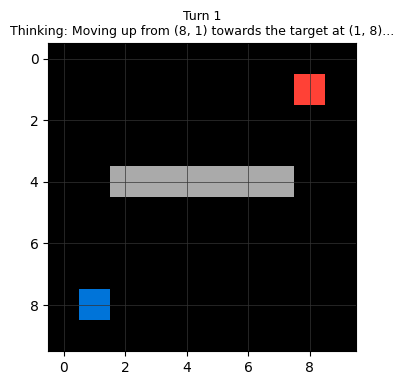

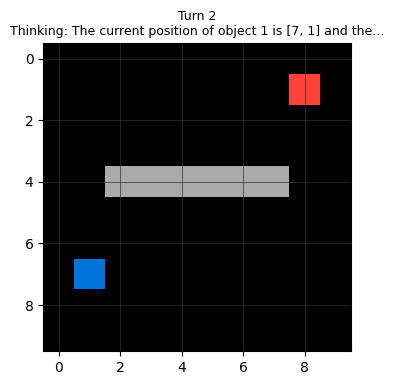

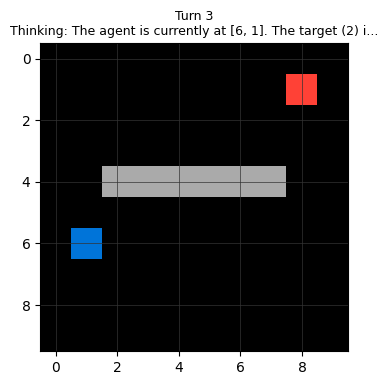

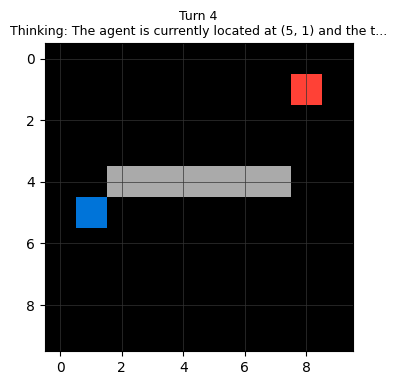

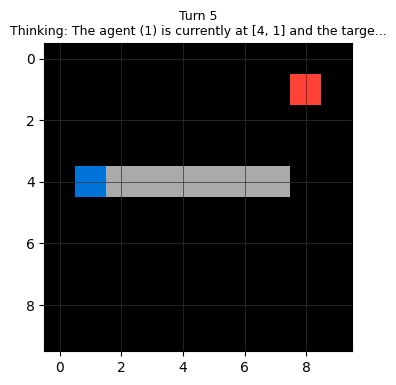

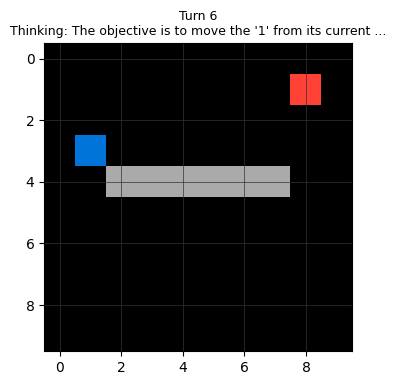

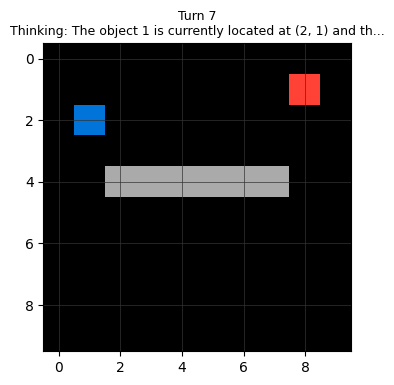

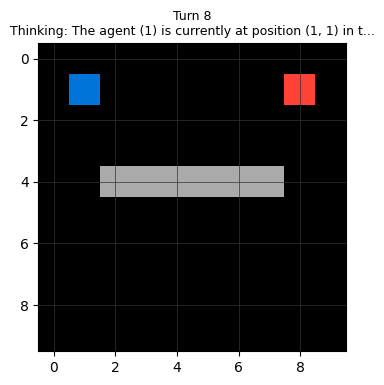

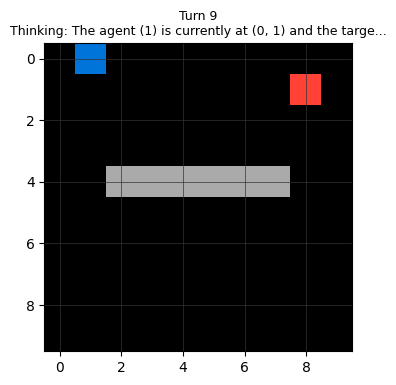

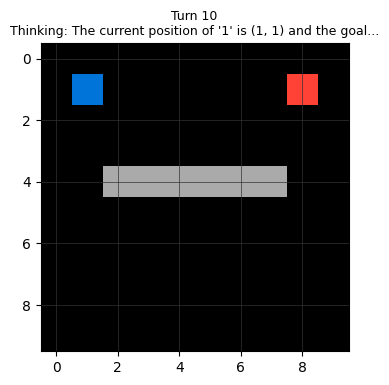

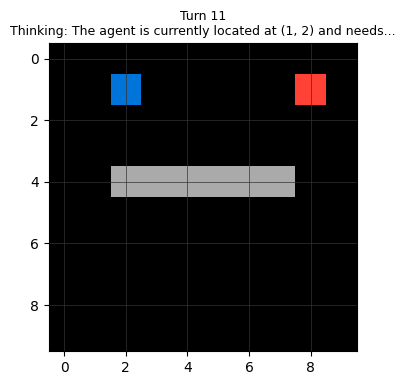

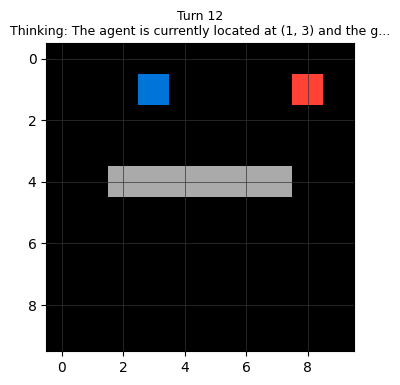

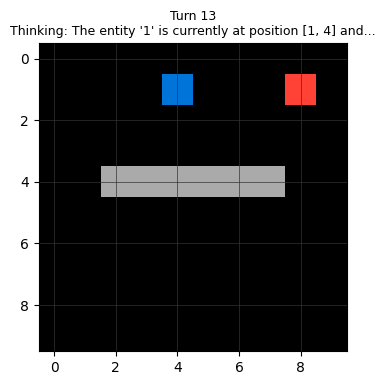

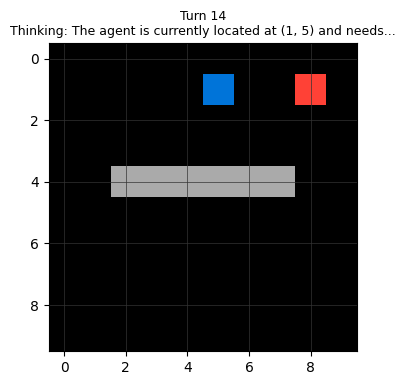

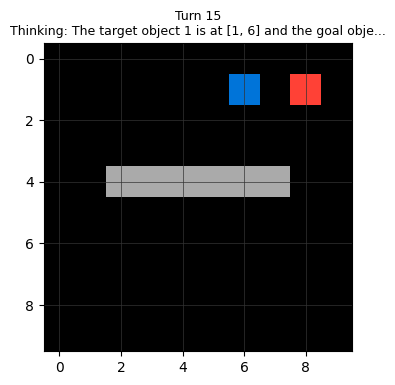

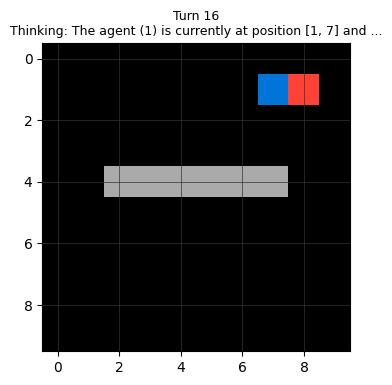


✅ MISSION ACCOMPLISHED!
------------------------------------
Total Turns Taken:    16
Optimal Turns:        14
Action Efficiency:    87.5%
Collision Count:      0
------------------------------------


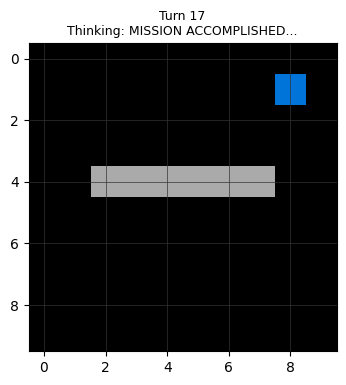

In [28]:
import json
import uuid
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from google import genai
from google.genai import types
from google.colab import userdata

# --- 1. LOCAL PHYSICS ENGINE WITH COLLISION TRACKING ---
class MockARCServer:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.state = "ACTIVE"
        self.guid = str(uuid.uuid4())
        self.player_pos = [8, 1]
        self.goal_pos = [1, 8]
        # Gray walls (Color 5)
        self.walls = [[4, x] for x in range(2, 8)]
        return self._get_frame()

    def step(self, action_id):
        self.guid = str(uuid.uuid4())
        r, c = self.player_pos
        new_r, new_c = r, c

        # 1:UP, 2:DOWN, 3:LEFT, 4:RIGHT
        if action_id == 1: new_r -= 1
        elif action_id == 2: new_r += 1
        elif action_id == 3: new_c -= 1
        elif action_id == 4: new_c += 1

        # Collision Logic: Block movement if it hits walls or boundaries
        collision = False
        if 0 <= new_r < self.grid_size and 0 <= new_c < self.grid_size:
            if [new_r, new_c] not in self.walls:
                self.player_pos = [new_r, new_c]
            else:
                collision = True
        else:
            collision = True

        if self.player_pos == self.goal_pos:
            self.state = "WIN"

        return self._get_frame(), collision

    def _get_frame(self):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for w_r, w_c in self.walls: grid[w_r, w_c] = 5
        grid[self.goal_pos[0], self.goal_pos[1]] = 2
        grid[self.player_pos[0], self.player_pos[1]] = 1
        return {"grid": grid.tolist(), "state": self.state, "guid": self.guid}

# --- 2. THE VISUALIZER ---
def plot_arc_grid(grid, turn, thought):
    arc_colors = ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', '#AAAAAA']
    cmap = colors.ListedColormap(arc_colors[:6])
    plt.figure(figsize=(4, 4))
    plt.imshow(grid, cmap=cmap, norm=colors.Normalize(vmin=0, vmax=5))
    plt.grid(True, which='both', color='#333333', linewidth=0.5)
    plt.title(f"Turn {turn}\nThinking: {thought[:50]}...", fontsize=9)
    plt.show()

# --- 3. GEMINI 3 FLASH AGENT ---
class Gemini3Agent:
    def __init__(self):
        self.client = genai.Client(api_key=userdata.get('GEMINI'))

    def act(self, grid, history):
        prompt = f"Grid: {grid}\nHistory: {history[-5:]}\nGoal: Move 1 to 2. Avoid 5. JSON: {{'thought': 'str', 'action_id': 1-4}}"
        config = types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(include_thoughts=True, thinking_level="high"),
            response_mime_type="application/json"
        )
        response = self.client.models.generate_content(model="gemini-3-flash-preview", contents=prompt, config=config)
        return json.loads(response.text)

# --- 4. EXECUTION LOOP WITH METRICS ---
def run_final_demo():
    server = MockARCServer()
    agent = Gemini3Agent()
    frame = server.reset()
    history = []

    # Trackers for Metrics
    start_pos = np.array([8, 1])
    goal_pos = np.array([1, 8])
    min_possible_turns = np.sum(np.abs(start_pos - goal_pos)) # Manhattan distance
    total_collisions = 0

    print("--- STARTING CORRECTED DEMO WITH METRICS ---")
    for turn in range(1, 21):
        # AI Planning
        decision = agent.act(frame["grid"], history)

        # Visual Update
        plot_arc_grid(frame["grid"], turn, decision['thought'])

        # Physical Update & Metrics Tracking
        frame, collided = server.step(decision['action_id'])
        if collided: total_collisions += 1
        history.append(f"ACTION{decision['action_id']}")

        if frame["state"] == "WIN":
            # Final Statistics
            efficiency = (min_possible_turns / turn) * 100
            print(f"\n✅ MISSION ACCOMPLISHED!")
            print(f"------------------------------------")
            print(f"Total Turns Taken:    {turn}")
            print(f"Optimal Turns:        {min_possible_turns}")
            print(f"Action Efficiency:    {efficiency:.1f}%")
            print(f"Collision Count:      {total_collisions}")
            print(f"------------------------------------")
            plot_arc_grid(frame["grid"], turn + 1, "MISSION ACCOMPLISHED")
            break

run_final_demo()

## 64x64 - - Offline ARC-AGI-3

--- STARTING 64x64 OFFLINE DEMO ---
Start: [59  5], Goal: [ 5 59], Min Turns: 108


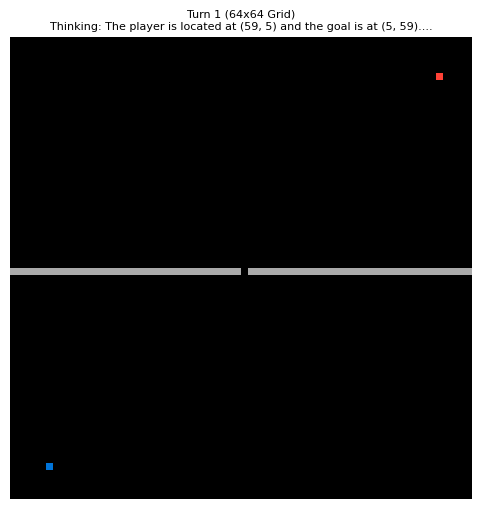

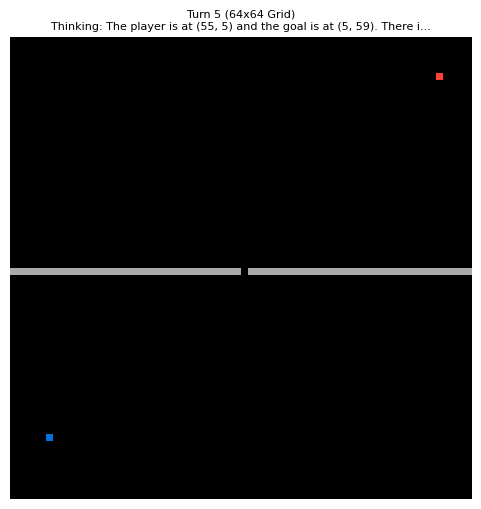

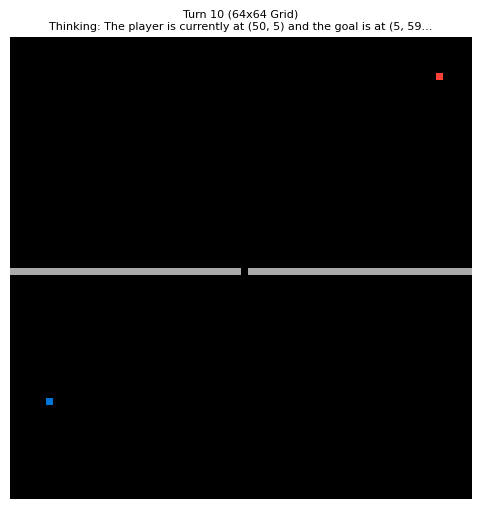

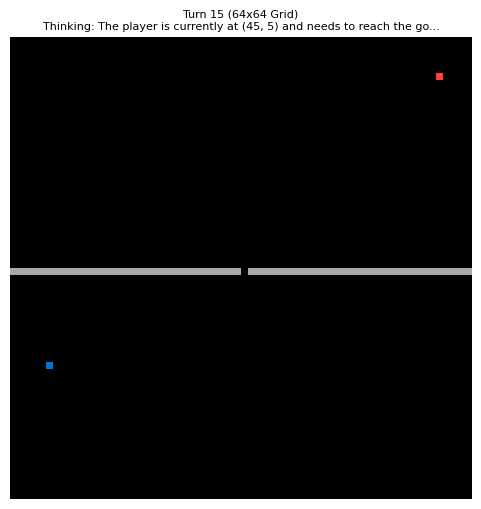

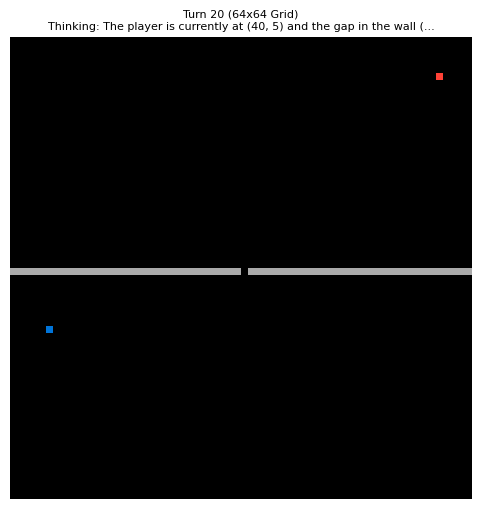

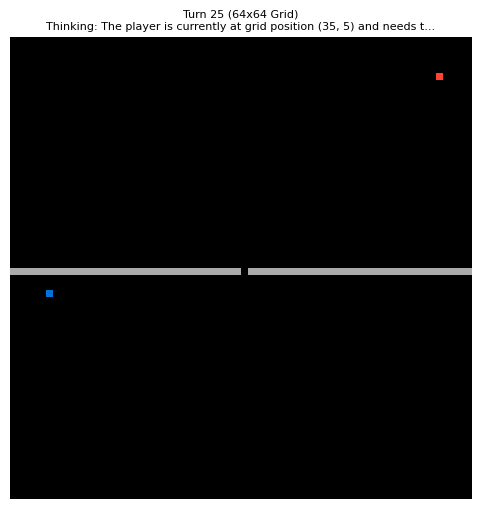

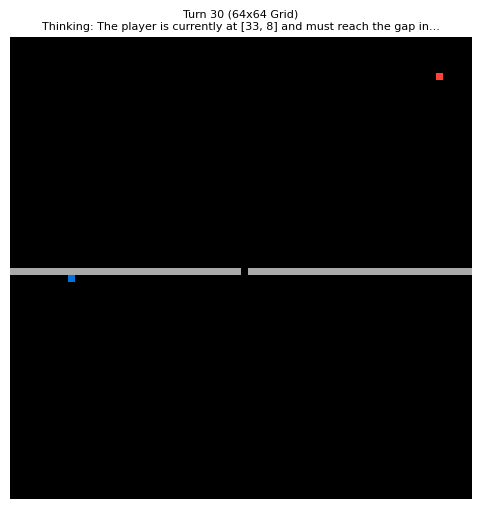

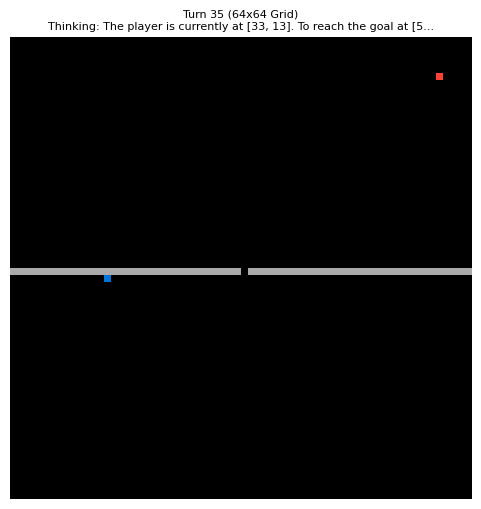

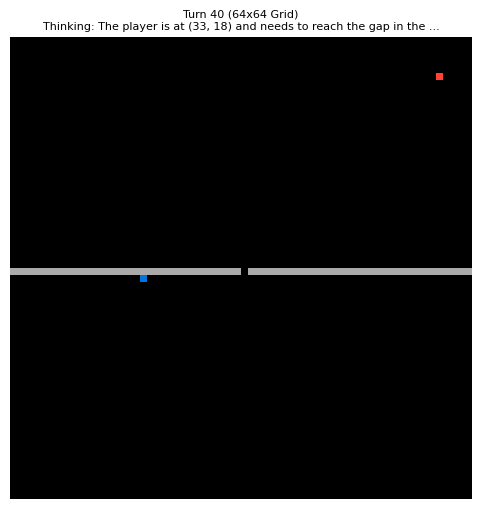

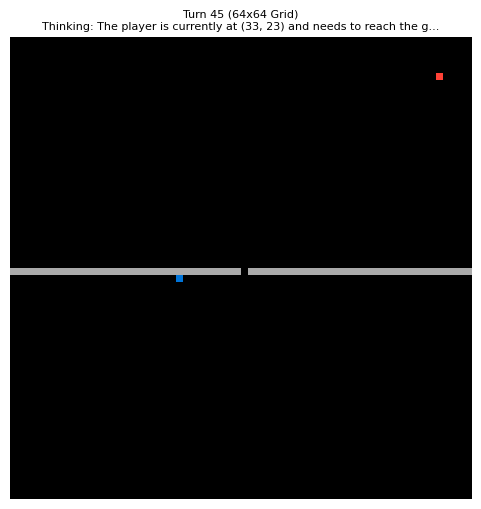

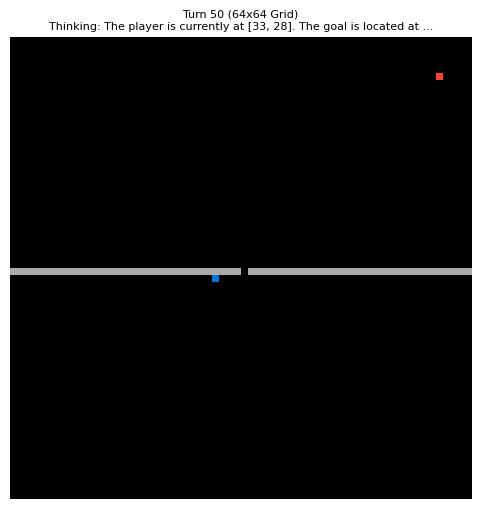

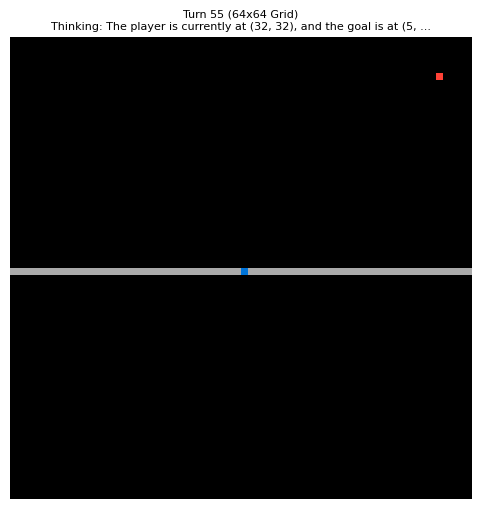

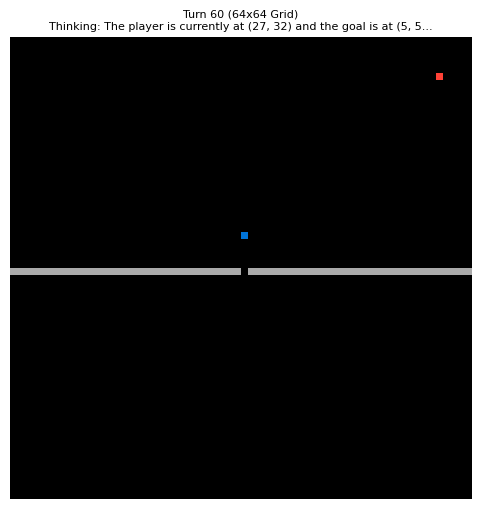

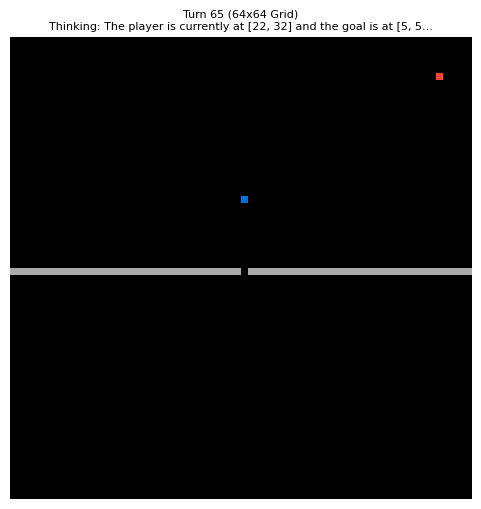

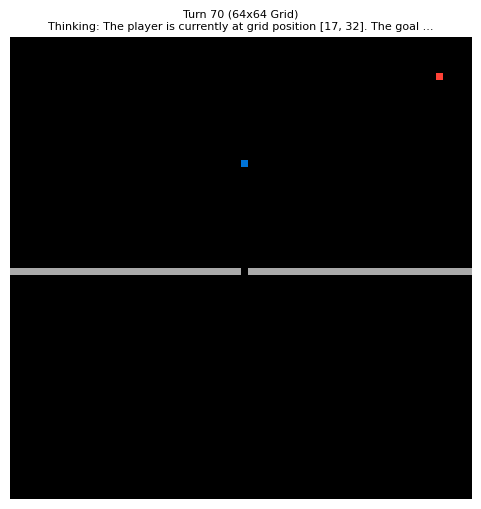

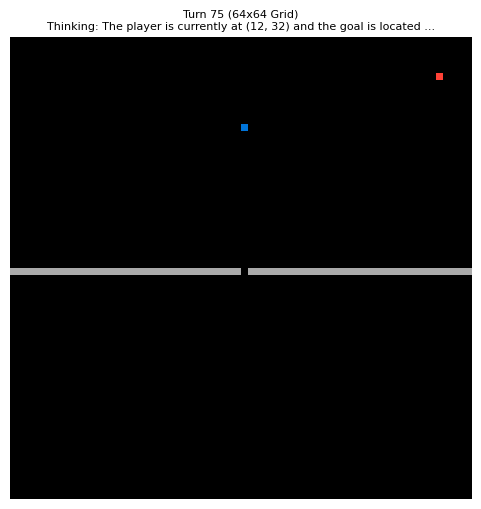

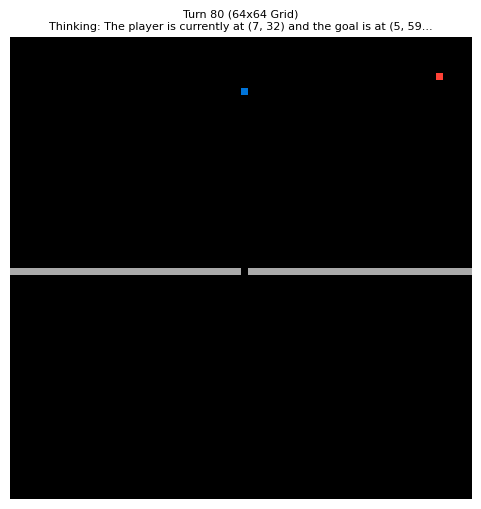

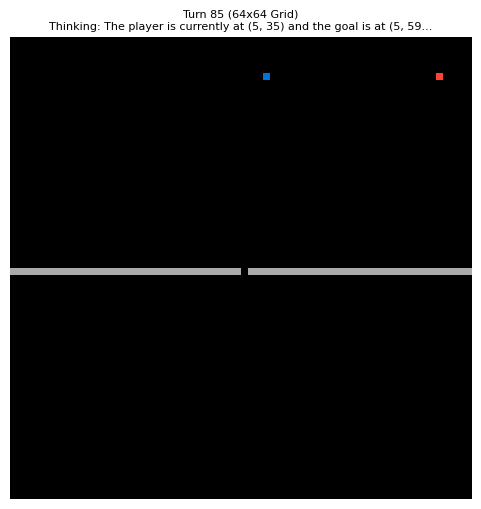

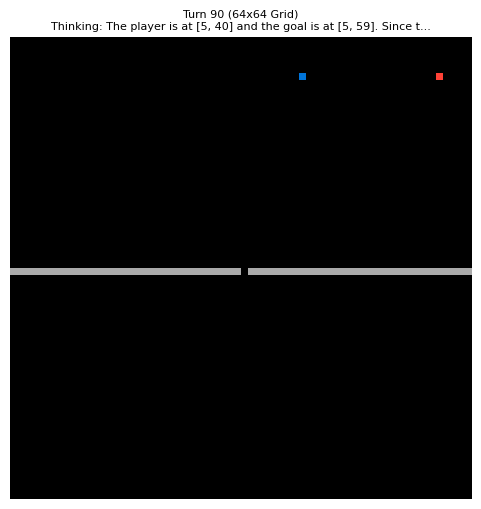

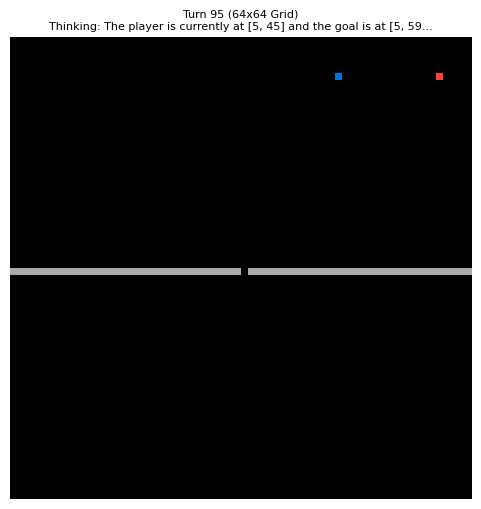

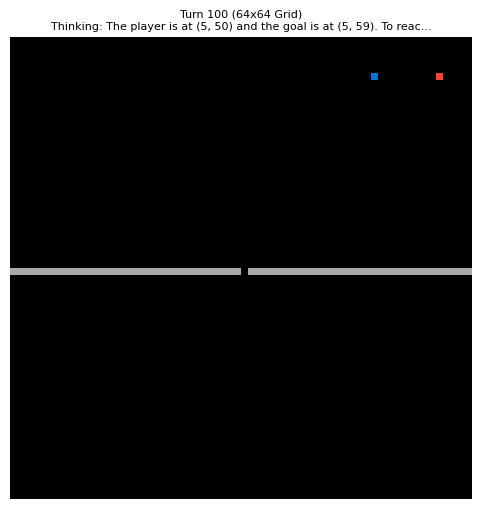

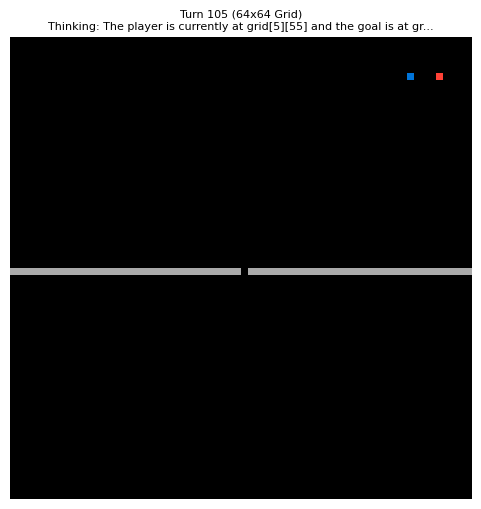


✅ MISSION ACCOMPLISHED AT TURN 108!
------------------------------------
Total Turns Taken:    108
Optimal Turns:        108
Action Efficiency:    100.0%
Collision Count:      0
------------------------------------


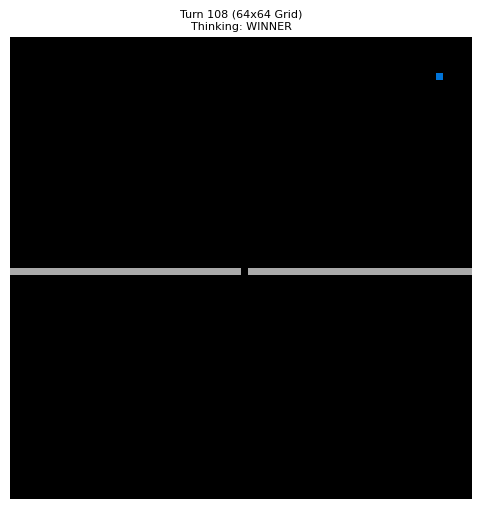

In [27]:
import json
import uuid
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from google import genai
from google.genai import types
from google.colab import userdata

# --- 1. LOCAL PHYSICS ENGINE UPDATED FOR 64x64 ---
class MockARCServer:
    def __init__(self, grid_size=64):
        self.grid_size = grid_size
        self.reset()

    def reset(self):
        self.state = "ACTIVE"
        self.guid = str(uuid.uuid4())

        # Start at one corner, Goal at the opposite corner for 64x64 scale
        self.player_pos = [self.grid_size - 5, 5]
        self.goal_pos = [5, self.grid_size - 5]

        # Define some walls to make it interesting
        # A horizontal wall in the middle with a gap
        mid = self.grid_size // 2
        self.walls = [[mid, x] for x in range(0, self.grid_size) if x != mid]

        return self._get_frame()

    def step(self, action_id):
        self.guid = str(uuid.uuid4())
        r, c = self.player_pos
        new_r, new_c = r, c

        # 1:UP, 2:DOWN, 3:LEFT, 4:RIGHT
        if action_id == 1: new_r -= 1
        elif action_id == 2: new_r += 1
        elif action_id == 3: new_c -= 1
        elif action_id == 4: new_c += 1

        # Collision Logic: Block movement if it hits walls or boundaries
        collision = False
        if 0 <= new_r < self.grid_size and 0 <= new_c < self.grid_size:
            if [new_r, new_c] not in self.walls:
                self.player_pos = [new_r, new_c]
            else:
                collision = True
        else:
            collision = True

        if self.player_pos == self.goal_pos:
            self.state = "WIN"

        return self._get_frame(), collision

    def _get_frame(self):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        for w_r, w_c in self.walls:
            if 0 <= w_r < self.grid_size and 0 <= w_c < self.grid_size:
                grid[w_r, w_c] = 5
        grid[self.goal_pos[0], self.goal_pos[1]] = 2
        grid[self.player_pos[0], self.player_pos[1]] = 1
        return {"grid": grid.tolist(), "state": self.state, "guid": self.guid}

# --- 2. THE VISUALIZER (Optimized for Large Grids) ---
def plot_arc_grid(grid, turn, thought):
    # Standard ARC Colors
    arc_colors = ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', '#AAAAAA']
    cmap = colors.ListedColormap(arc_colors[:6])

    plt.figure(figsize=(6, 6)) # Larger figure for 64x64
    plt.imshow(grid, cmap=cmap, norm=colors.Normalize(vmin=0, vmax=5))

    # Grid lines are less useful at 64x64 resolution, so we make them very thin
    plt.grid(True, which='both', color='#333333', linewidth=0.2)

    # Title showing short thinking process
    display_thought = str(thought)[:60] + "..." if len(str(thought)) > 60 else str(thought)
    plt.title(f"Turn {turn} (64x64 Grid)\nThinking: {display_thought}", fontsize=8)
    plt.axis('off') # Hide axis for cleaner look at large scale
    plt.show()

# --- 3. ROBUST GEMINI 3 FLASH AGENT ---
class Gemini3Agent:
    def __init__(self):
        # Ensure 'GEMINI' key is in Colab Secrets
        self.client = genai.Client(api_key=userdata.get('GEMINI'))

    def act(self, grid, history):
        # We limit the grid string because 64x64 is large
        prompt = (
            f"Objective: Move the player (Color 1) to the Goal (Color 2). Avoid Walls (Color 5).\n"
            f"Current Grid: {grid}\n"
            f"Recent History: {history[-10:]}\n"
            f"Instructions: Output JSON with 'thought' and 'action_id' (1:UP, 2:DOWN, 3:LEFT, 4:RIGHT)."
        )

        config = types.GenerateContentConfig(
            thinking_config=types.ThinkingConfig(include_thoughts=True, thinking_level="high"),
            response_mime_type="application/json"
        )

        try:
            response = self.client.models.generate_content(
                model="gemini-3-flash-preview",
                contents=prompt,
                config=config
            )

            # FIX FOR THE LIST ERROR:
            # Sometimes models wrap JSON in a list [ {} ]
            res_data = json.loads(response.text)
            if isinstance(res_data, list):
                return res_data[0]
            return res_data
        except Exception as e:
            print(f"Error parsing model response: {e}")
            return {"thought": "Error occurred, defaulting to UP", "action_id": 1}

# --- 4. EXECUTION LOOP WITH 64x64 METRICS ---
def run_final_demo():
    grid_size = 64
    server = MockARCServer(grid_size=grid_size)
    agent = Gemini3Agent()

    frame = server.reset()
    history = []

    # Calculate optimal path (Manhattan Distance)
    start_pos = np.array([grid_size - 5, 5])
    goal_pos = np.array([5, grid_size - 5])
    min_possible_turns = np.sum(np.abs(start_pos - goal_pos))

    total_collisions = 0
    max_turns = 150 # Increased for larger grid

    print(f"--- STARTING 64x64 OFFLINE DEMO ---")
    print(f"Start: {start_pos}, Goal: {goal_pos}, Min Turns: {min_possible_turns}")

    for turn in range(1, max_turns + 1):
        # 1. AI Planning
        decision = agent.act(frame["grid"], history)

        # Extract fields safely using .get()
        thought = decision.get('thought', 'No logic provided')
        action_id = decision.get('action_id', 1)

        # 2. Visual Update (Now robust against list/dict errors)
        if turn % 5 == 0 or turn == 1: # Only plot every 5 turns to avoid spamming
            plot_arc_grid(frame["grid"], turn, thought)

        # 3. Physical Update
        # IMPORTANT: Unpack into new variables to keep 'frame' as the latest dict
        next_frame, collided = server.step(action_id)
        frame = next_frame

        if collided:
            total_collisions += 1

        history.append(f"Turn {turn}: Action {action_id}")

        if frame["state"] == "WIN":
            efficiency = (min_possible_turns / turn) * 100
            print(f"\n✅ MISSION ACCOMPLISHED AT TURN {turn}!")
            print(f"------------------------------------")
            print(f"Total Turns Taken:    {turn}")
            print(f"Optimal Turns:        {min_possible_turns}")
            print(f"Action Efficiency:    {efficiency:.1f}%")
            print(f"Collision Count:      {total_collisions}")
            print(f"------------------------------------")
            plot_arc_grid(frame["grid"], turn, "WINNER")
            break

    if frame["state"] != "WIN":
        print(f"❌ Failed to reach goal within {max_turns} turns.")

# Execute the corrected demo
run_final_demo()